### Import the necessary modules

In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random
import os
import scipy.sparse as sp
import tensorflow as tf
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, Dropout, ReLU, Sigmoid, ELU
from torch_geometric.nn import GCNConv, GINConv, GATv2Conv, SAGEConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, scatter
import time
import matplotlib.pyplot as plt
import pandas as pd
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx
from torch_geometric.utils import degree
from collections import Counter

#### Set seed for reproducibility 

In [36]:
def set_seed(seed):
    random.seed(seed)  # Seed for the random module
    np.random.seed(seed)  # Seed for NumPy
    torch.manual_seed(seed)  # Seed for PyTorch
    torch.cuda.manual_seed(seed)  # Seed for current GPU
    torch.cuda.manual_seed_all(seed)  # Seed for all GPUs (if you have more than one)

# Set the desired seed
set_seed(42)

### Import the required datafile and prepare the data in the required graph structure

In [37]:
file_str="RWs_H_g_2_tadv_5min_localized_area"
file_str_test = "RWs_H_g_2_tadv_5min_localized_area_test"

data = np.load(file_str+".npz")
data_test = np.load(file_str_test+".npz")

wave_data_train=data["wave_data_train"][:2000]
wave_data_test=data_test["wave_data_test"]
label_train=data["label_train"][:2000]
label_test=data_test["label_test"]
buoy_mask_train=data["buoy_mask_train"][:2000]
buoy_mask_test=data_test["buoy_mask_test"]

num_classes=2

num_nodes = wave_data_train.shape[0] +  wave_data_test.shape[0]
num_node_features = wave_data_train.shape[1]

print("----------------The graph structure will be in the form of a single graph------------------".upper())
print("--The graph will have multiple nodes where each node is a time series sample--".upper())
print("----------------------------The feature length of each node is the length of the time series----------------------------".upper())
print('\n')
print('-----------------------The graph properties are given below---------------------\n'.upper())
print(f"The number of nodes in the graph is {num_nodes}")
print(f"The number of features for each node is {num_node_features}")
print(f"The number of training set examples is {wave_data_train.shape[0]}")
print(f"The number of test set examples is {wave_data_test.shape[0]}")

----------------THE GRAPH STRUCTURE WILL BE IN THE FORM OF A SINGLE GRAPH------------------
--THE GRAPH WILL HAVE MULTIPLE NODES WHERE EACH NODE IS A TIME SERIES SAMPLE--
----------------------------THE FEATURE LENGTH OF EACH NODE IS THE LENGTH OF THE TIME SERIES----------------------------


-----------------------THE GRAPH PROPERTIES ARE GIVEN BELOW---------------------

The number of nodes in the graph is 2340
The number of features for each node is 1152
The number of training set examples is 2000
The number of test set examples is 340


In [38]:
wave_data_train_df= pd.DataFrame(data=wave_data_train.reshape(wave_data_train.shape[0], wave_data_train.shape[1]))
wave_data_test_df= pd.DataFrame(data=wave_data_test.reshape(wave_data_test.shape[0], wave_data_test.shape[1]))
combined_wave_data_nodes = pd.concat([wave_data_train_df, wave_data_test_df], axis=0)

labels = np.concatenate((label_train, label_test), axis=0)
buoy_masks = np.concatenate((buoy_mask_train, buoy_mask_test), axis=0)

train_masks = np.zeros(len(labels))
for i in range(len(train_masks)):
    if i<len(label_train):
        train_masks[i] = 1
    else:
        train_masks[i] = 0
combined_wave_data_nodes['labels'] = labels
combined_wave_data_nodes['buoy_masks'] = buoy_masks
combined_wave_data_nodes['train_masks'] = train_masks

combined_wave_info = np.array(combined_wave_data_nodes)
permuted_indices = np.random.permutation(combined_wave_info.shape[0])
combined_wave_info = combined_wave_info[permuted_indices]

In [39]:
combined_wave_data_

,0,1,2,3,4,5,6,7,8,9,...,1145,1146,1147,1148,1149,1150,1151,labels,buoy_masks,train_masks
0,0.126167,0.153254,0.288689,0.327814,0.219466,0.123157,0.087041,-0.027326,-0.099558,-0.081500,...,-0.177809,-0.141693,-0.093539,-0.126645,-0.129655,0.008790,0.081022,1.0,0,1.0
1,0.055999,-0.017231,0.017231,-0.107691,-0.081845,-0.180921,-0.314458,-0.167998,-0.159383,-0.137844,...,-0.236920,-0.249843,-0.232612,-0.314458,-0.499686,-0.525532,-0.387687,0.0,0,1.0
2,0.032631,0.064990,0.207368,0.310915,0.459765,0.530954,0.252670,0.039103,-0.129162,-0.290955,...,0.103820,0.116764,-0.051501,-0.232710,-0.290955,-0.180936,0.064990,1.0,0,1.0
3,-0.068579,-0.024007,0.105836,0.248728,0.280341,0.228766,0.177696,0.091910,0.072100,0.091908,...,-0.169046,-0.059017,-0.120082,-0.164871,-0.027757,0.038351,-0.028221,1.0,0,1.0
4,0.062493,0.010438,-0.145728,-0.229016,-0.114494,0.052082,0.187426,0.208248,0.072904,-0.135317,...,0.218659,0.114549,0.114549,0.218659,0.093727,-0.166550,-0.124905,1.0,1,1.0


#### Create the normalized distances matrix for assigning edge weights based on buoys

In [40]:
distances = [[0.00, 27.86,43.21, 84.34, 95.40],
                 [-27.86, 0.00, 16.92, 68.93, 68.23],
                 [-43.21, 16.92, 0.00, 55.76, 52.20],
                 [-84.34, -68.93, -55.76, 0.00, 58.41],
                 [-95.40, -68.23, -52.20, -58.41, 0.00]]

max_dist = max(max(distances))
norm_dist = []
for i in range(len(distances)):
    buoy_list = []
    for j in range(len(distances[0])):
        if distances[i][j] >= 0:
            buoy_list.append(1 - (distances[i][j] / max_dist))
        else:
            buoy_list.append(0)
    norm_dist.append(buoy_list)

In [41]:
norm_dist

[[1.0, 0.7079664570230608, 0.5470649895178197, 0.1159329140461216, 0.0],
 [0, 1.0, 0.8226415094339623, 0.2774633123689727, 0.2848008385744235],
 [0, 0.8226415094339623, 1.0, 0.41551362683438164, 0.4528301886792453],
 [0, 0, 0, 1.0, 0.38773584905660385],
 [0, 0, 0, 0, 1.0]]

#### Creation of edges and edge weights 

In [44]:
num_samples = combined_wave_info.shape[0]

edge_file_path = os.getcwd() + f"\edge_data_local_original_node_classification_new_graphsage7.npz"

if os.path.exists(edge_file_path):
    edge_data=np.load(edge_file_path)
    edge_indices_start=edge_data["edge_start"]
    edge_indices_end=edge_data["edge_end"]
    edge_weights = edge_data["edge_weights"]

else:
    ### For the creation of edges between the different nodes, we are looking at the correlation between the different time series samples
    ### The edges are created if the correlation exceeds a certain threshold
    
    edge_indices_start = []
    edge_indices_end = []
    edge_weights_list = []
    for i in range(num_samples):
        buoy_i = combined_wave_info[i,-2].astype(int)
        num_immediate_neighbours = 0
        num_other_neighbours = 0
        skip_inner_loop = False
        for j in range(num_samples):
            buoy_j = combined_wave_info[j,-2].astype(int)
            if norm_dist[buoy_i][buoy_j] > 0:
                if buoy_i == buoy_j:
                    num_immediate_neighbours +=1
                    edge_indices_start.append(i)
                    edge_indices_end.append(j)
                    edge_weights_list.append(norm_dist[buoy_i][buoy_j])
                    if num_immediate_neighbours >= 400:
                        skip_inner_loop = True
                        break
                else:
                    num_other_neighbours +=1
                    edge_indices_start.append(i)
                    edge_indices_end.append(j)
                    edge_weights_list.append(norm_dist[buoy_i][buoy_j])
                    if num_other_neighbours >= 500:
                        skip_inner_loop = True
                        break
            if skip_inner_loop:
                continue
                        
    np.savez(edge_file_path,edge_start=edge_indices_start, edge_end=edge_indices_end, edge_weights=edge_weights_list)

    edge_data=np.load(edge_file_path)
    edge_indices_start=edge_data["edge_start"]
    edge_indices_end=edge_data["edge_end"]
    edge_weights = edge_data["edge_weights"]

edge_indices = [edge_indices_start, edge_indices_end]

### Create the graph data using the above information

In [45]:
x = torch.tensor(combined_wave_info[:,:-3], dtype=torch.float)
y = torch.tensor(combined_wave_info[:,-3], dtype=torch.float)
edge_index = torch.tensor(edge_indices, dtype = torch.long)
edge_weight = torch.tensor(edge_weights, dtype=torch.float)
                          
graph_data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_weight)

train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

train_val_indices = np.where(combined_wave_info[:,-1] == 1.0)[0]
train_val_ratio = 0.7
train_indices = train_val_indices[:int(train_val_ratio * len(train_val_indices))]
val_indices = train_val_indices[int(train_val_ratio * len(train_val_indices)):]
test_indices = np.where(combined_wave_info[:,-1] == 0.0)[0]

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

graph_data.train_mask = train_mask
graph_data.val_mask = val_mask
graph_data.test_mask = test_mask

print(f'\nGraph:'.upper())
print('------')
print(f"Total number of edges: {len(graph_data.edge_index[0])}".upper())
print(f'Training nodes: {sum(graph_data.train_mask).item()}'.upper())
print(f'Evaluation nodes: {sum(graph_data.val_mask).item()}'.upper())
print(f'Test nodes: {sum(graph_data.test_mask).item()}'.upper())


GRAPH:
------
TOTAL NUMBER OF EDGES: 1253954
TRAINING NODES: 1400
EVALUATION NODES: 600
TEST NODES: 340


In [46]:
edge_index

tensor([[   0,    0,    0,  ..., 2339, 2339, 2339],
        [   0,    1,    2,  ...,  603,  604,  605]])

#### Just check the pytorch and cuda versions for installing version compatible packages

In [47]:
print("PyTorch version:", torch.__version__)

# Check CUDA version (if available)
if torch.cuda.is_available():
    print("CUDA version:", torch.version.cuda)
else:
    print("CUDA is not available.")

PyTorch version: 2.4.0+cu124
CUDA version: 12.4


#### Hyperparameters which can be used later

In [48]:
batch_size = 64
pri_neighbours = 5
sec_neighbours = 10

#### Create the dataloaders using neighbour samples and visulaize some of the subgraphs

C:\Users\samar\AppData\Local\Temp\ipykernel_29492\681521225.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


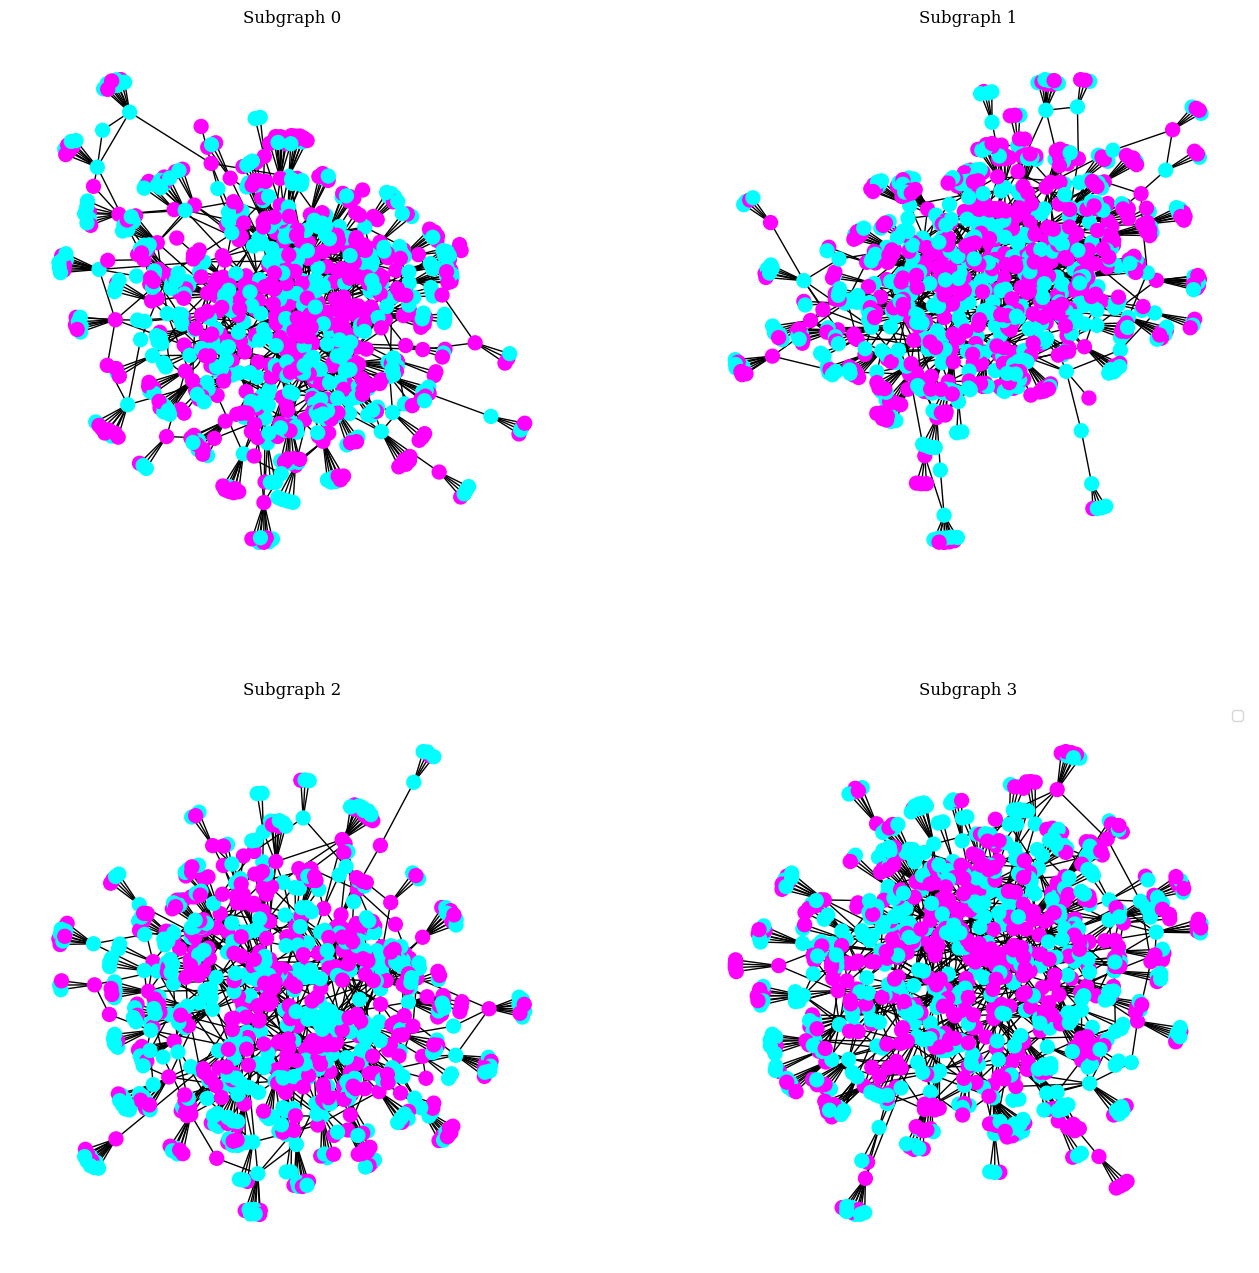

<Figure size 800x800 with 0 Axes>

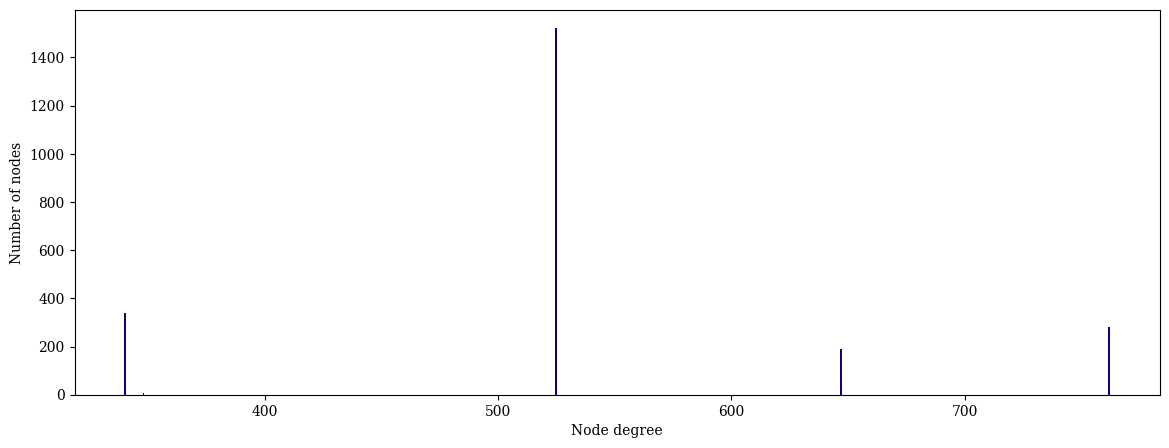

In [78]:
# Create batches with neighbor sampling
train_loader = NeighborLoader(
    graph_data,
    num_neighbors=[pri_neighbours, sec_neighbours],
    batch_size=batch_size,
    input_nodes=graph_data.train_mask,
)

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=False,
                    node_size=100,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=3
                    )
plt.legend()
plt.savefig("A sample subgraph during node classification.jpg")
plt.show()

def plot_degree(data):
    # Get list of degrees for each node
    degrees = degree(data.edge_index[0]).numpy()

    # Count the number of nodes for each degree
    numbers = Counter(degrees)

    # Bar plot
    fig, ax = plt.subplots(figsize=(14,5))
    ax.set_xlabel('Node degree')
    ax.set_ylabel('Number of nodes')
    plt.bar(numbers.keys(),
            numbers.values(),
            color='#0A047A')

plt.figure(figsize=[8,8])
# Plot node degrees from the original graph
plot_degree(graph_data)
# Plot node degrees from the last subgraph
# plot_degree(subdata)
plt.savefig("Node degrees for all nodes and a subgraph structure.jpg")

#### Create the LSTM time series module that will be utilized in the spatio-temporal classification 

In [50]:
class LSTM_Graph(nn.Module):
    def __init__(self, input_dim, lstm_hidden_dim, num_lstm_layers, dropout, training):
        super(LSTM_Graph, self).__init__()

        self.input_dim = input_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.num_lstm_layers = num_lstm_layers
        self.training = training

        self.lstm_layers = nn.ModuleList()
        self.layerNorm_layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout)
        
        for i in range(self.num_lstm_layers):
            if i==0:
                lstm_layer = nn.LSTM(self.input_dim, self.lstm_hidden_dim, batch_first=True)
                self.lstm_layers.append(lstm_layer)
                self.layerNorm_layers.append(nn.LayerNorm(self.lstm_hidden_dim))
            else:
                lstm_layer = nn.LSTM(self.lstm_hidden_dim, self.lstm_hidden_dim, batch_first=True)
                self.lstm_layers.append(lstm_layer)
                self.layerNorm_layers.append(nn.LayerNorm(self.lstm_hidden_dim))

    def forward(self, x):
        ## Initialize the hidden and cell states for each LSTM layer
        h_n, c_n = [None] * self.num_lstm_layers, [None] * self.num_lstm_layers

        for i in range(self.num_lstm_layers):
            x, (h_n[i], _) = self.lstm_layers[i](x)
            
            # Apply layer normalization to the output of the current LSTM layer
            x = self.layerNorm_layers[i](x)
            
            # Apply dropout if not the last layer
            if self.training:
                x = self.dropout(x)

        return h_n[-1]

#### Create the GraphSAGE module to be utilized in the spatio-temporal classification 

In [51]:
class SAGE_Graph(nn.Module):
    def __init__(self, num_sage_layers, sage_idim, sage_hdim, dropout, training):
        super(SAGE_Graph, self).__init__()

        self.num_sage_layers = num_sage_layers
        self.sage_idim = sage_idim
        self.sage_hdim = sage_hdim 
        self.training = training
        
        self.dropout = Dropout(dropout)
        self.relu = ReLU()

        self.sage_layers = nn.ModuleList()

        for i in range(self.num_sage_layers):
            if i==0:
                sage_layer = SAGEConv(self.sage_idim, self.sage_hdim)
                self.sage_layers.append(sage_layer)
            else:
                sage_layer = SAGEConv(self.sage_hdim, self.sage_hdim)
                self.sage_layers.append(sage_layer)

    def forward(self, x, edge_index, edge_weight):

        for k in range(self.num_sage_layers):
            if k==0:
                if self.training:
                    sage_out = self.relu(self.sage_layers[k](x, edge_index))
                    sage_out = self.dropout(sage_out)
                else:
                    sage_out = self.relu(self.sage_layers[k](x, edge_index))
            else:
                if self.training:
                    sage_out = self.relu(self.sage_layers[k](sage_out, edge_index))
                    sage_out = self.dropout(sage_out)
                else:
                    sage_out = self.relu(self.sage_layers[k](sage_out, edge_index))
        return sage_out    

### Create the SAGE+LSTM network for node-level time series classification

In [52]:
import torch.nn.functional as F
class SpatioTemporalSAGE(torch.nn.Module):
    """
    Creates a gnn model based on global pooling of embeddings - for graph level classifications
    """
    def __init__(self, num_sage_layers, sage_hdim, dropout_prob, num_lstm_layers, lstm_hdim, training=True):
        
        self.num_sage_layers = num_sage_layers
        self.sage_hdim = sage_hdim
        self.dropout_prob = dropout_prob
        self.num_lstm_layers = num_lstm_layers
        self.lstm_hdim = lstm_hdim
        self.training = training

        super(SpatioTemporalSAGE, self).__init__()

        self.temporal_module = LSTM_Graph(1, self.lstm_hdim, self.num_lstm_layers, self.dropout_prob, self.training)
        self.spatial_module = SAGE_Graph(self.num_sage_layers, self.lstm_hdim, self.sage_hdim, self.dropout_prob, self.training)
        self.fc = Linear(self.lstm_hdim+1, 2)

    def forward(self, x, edge_index, edge_weight):
        # print(f"The shape of the input at the start of the spatio-temporal module is {x.shape}")
        x_lstm = x.unsqueeze(2)
        # print(f"The shape of the input at the start of the temporal module is {x_lstm.shape}")
        
        batch_size, seqeunce_len, _ = x_lstm.size()
        # lstm_outputs = []
        # for i in range(batch_size):
        #     lstm_outputs.append(self.temporal_module(x_lstm[i]))
        # print(lstm_outputs[0].shape)
        # print(len(lstm_outputs))
        # lstm_out = torch.stack(lstm_outputs, dim=0)
        
        
        lstm_out = torch.stack([self.temporal_module(x_lstm[i]) for i in range(batch_size)], dim=0)
        # print(f"The shape of the input at the end of the temporal module is {lstm_out.shape}")

        sage_in = lstm_out.view(-1, lstm_out.shape[2])
        # print(f"The shape of the input at the start of the spatial module is {gcn_in.shape}")

        sage_out = self.spatial_module(sage_in, edge_index, edge_weight)
        # print(f"The shape of the input at the end of the spatial module is {gcn_out.shape}")

        concatenated_features = torch.cat([gcn_in, torch.mean(gcn_out, dim=1, keepdim=True)], dim=1)
        # concatenated_features = torch.cat([sage_in, sage_out], dim=1)
        # print(f"The shape of the concatenated features is {concatenated_features.shape}")

        out = self.fc(concatenated_features)
        # print(f"The shape of the output is {out.shape}")

        return F.log_softmax(out, dim=1)

#### Hyperparameters to be used

In [53]:
num_sage_layers = 2
sage_hdim = 32
dropout_prob = 0.1
num_lstm_layers = 2
lstm_hdim = 32

patience_new = 10

#### File save names to be used for saving of the metrics and model

In [54]:
file_str = f"NodeClassification_Local_Originallength_SAGE_LSTM"
curves_filename = os.getcwd()+'/training_history_'+'/'+ file_str +'.jpg'
model_filename = os.getcwd()+'/model_saves_'+'/'+ file_str +'.pt'
accuracy_filename = os.getcwd()+'/accuracy_saves_'+'/'+ file_str+'.txt'
time_filename = os.getcwd()+'/time_saves_'+'/'+ file_str+'.txt'

#### Accuracy computation

In [55]:
# def compute_accuracy(preds, labels):
#     # print(f"Output:{preds}")
#     # print(f"Labels:{labels}")
#     predicted_classes = (preds > 0.5).float()
#     # print(f"Predicted classes:{predicted_classes}")
#     num_correct = (predicted_classes == labels).float().sum()
#     # print(f"Number of correctly predicted results: {num_correct}")
#     # print(f"Total number of items: {labels.shape[0]}")
#     accuracy = num_correct / labels.shape[0]
#     return accuracy.item()

In [56]:
def compute_accuracy(preds, labels):
    # print(f"Output:{preds}")
    # print(f"Labels:{labels}")
    _, pred_classes = torch.max(preds, dim=1)
    # print(f"Predicted classes:{pred_classes}")
    num_correct = (pred_classes == labels).float().sum()
    # print(f"Number of correctly predicted results: {num_correct}")
    # print(f"Total number of items: {labels.shape[0]}")
    accuracy = num_correct / labels.shape[0]
    # print(accuracy)
    return accuracy.item()

In [57]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

### Training and validation loops

In [68]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def trainVal(model):
    # criterion = torch.nn.BCELoss()
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay= 1e-3)
    # scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5)

    num_epochs = 1

    ##Early stopping parameters
    best_val_loss = float('inf')
    patience = patience_new
    counter = 0
    best_model_path = model_filename

    ## Keep track of the losses and accuracies over epochs
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []
    
    for epoch in range(num_epochs+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        for batch in train_loader:
            optimizer.zero_grad()
            # print(batch.edge_index.max().item())
            # print(batch.edge_index.min().item())
            
            output = model(batch.x, batch.edge_index, batch.edge_weight)
            # print(f"Output shape is:{output.shape}")
            # loss = criterion(output[graph_data.train_mask], graph_data.y[graph_data.train_mask].reshape(-1,1))
            loss = criterion(output[batch.train_mask], batch.y[batch.train_mask].long())
            total_loss += loss
            acc += accuracy(output[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask].long())

            ## Backward propagation and optimization 
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=0.5)
            optimizer.step()

            ### Validation losses
            val_loss += criterion(output[batch.val_mask], batch.y[batch.val_mask].long())
            val_acc += accuracy(output[batch.val_mask].argmax(dim=1), batch.y[batch.val_mask].long())

        train_loss = total_loss.detach().numpy() / len(train_loader)
        v_loss = val_loss.detach().numpy()  / len(train_loader)
        train_acc = acc  / len(train_loader)
        v_acc = val_acc  / len(train_loader)

        # scheduler.step(val_loss)

        training_losses.append(train_loss)
        training_accuracies.append(train_acc)

        validation_losses.append(v_loss)
        validation_accuracies.append(v_acc)

        ## print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {train_loss:.2f}'
              f'| Train Acc: {train_acc*100:4.3f}% '
              f'| Val Loss: {v_loss:.2f} '
              f'| Val Acc: {v_acc*100: 4.3f}%')

        ### Check for the validation loss improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), best_model_path)
            # print(f'Saving the model with val loss: {val_loss:.4f}')
        else:
            counter +=1

        ### Early stopping condition
        if counter >= patience:
            print("Early stopping triggered.")
            break

    ## Put the losses and accuracies in a dictionary which can be returned
    losses = {"Train loss": training_losses,
              "Train accuracy": training_accuracies,
              "Validation loss": validation_losses,
              "Validation accuracy": validation_accuracies}

    return losses

### Prediction loop

In [69]:
@torch.no_grad()
def test(model):
    # criterion = torch.nn.BCELoss()
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
  
    output = model(graph_data.x, graph_data.edge_index, graph_data.edge_weight)
    # test_loss = criterion(output[graph_data.test_mask], graph_data.y[graph_data.test_mask].reshape(-1,1)).item()
    test_loss = criterion(output[graph_data.test_mask], graph_data.y[graph_data.test_mask].long()).item()
    # test_acc = compute_accuracy(output[graph_data.test_mask], graph_data.y[graph_data.test_mask].reshape(-1,1))
    test_acc = compute_accuracy(output[graph_data.test_mask], graph_data.y[graph_data.test_mask].long())

    testing_loss = test_loss
    testing_acc = test_acc

    return testing_loss, testing_acc

#### Traning the model

In [70]:
start_time = time.time()

training=True
### Training and evaluation of the model
model = SpatioTemporalSAGE(num_sage_layers, sage_hdim, dropout_prob, num_lstm_layers, lstm_hdim, training=True)
train_val_metrics = trainVal(model)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time is {elapsed_time / 60:3.2f} minutes.") 

Epoch   0 | Train Loss: 0.69| Train Acc: 50.151% | Val Loss: 0.69 | Val Acc:  50.581%
Elapsed time is 10.54 minutes.


In [71]:
elapsed_time = np.array([round(elapsed_time, 4)])
np.savetxt(time_filename, elapsed_time, fmt='%.4f')

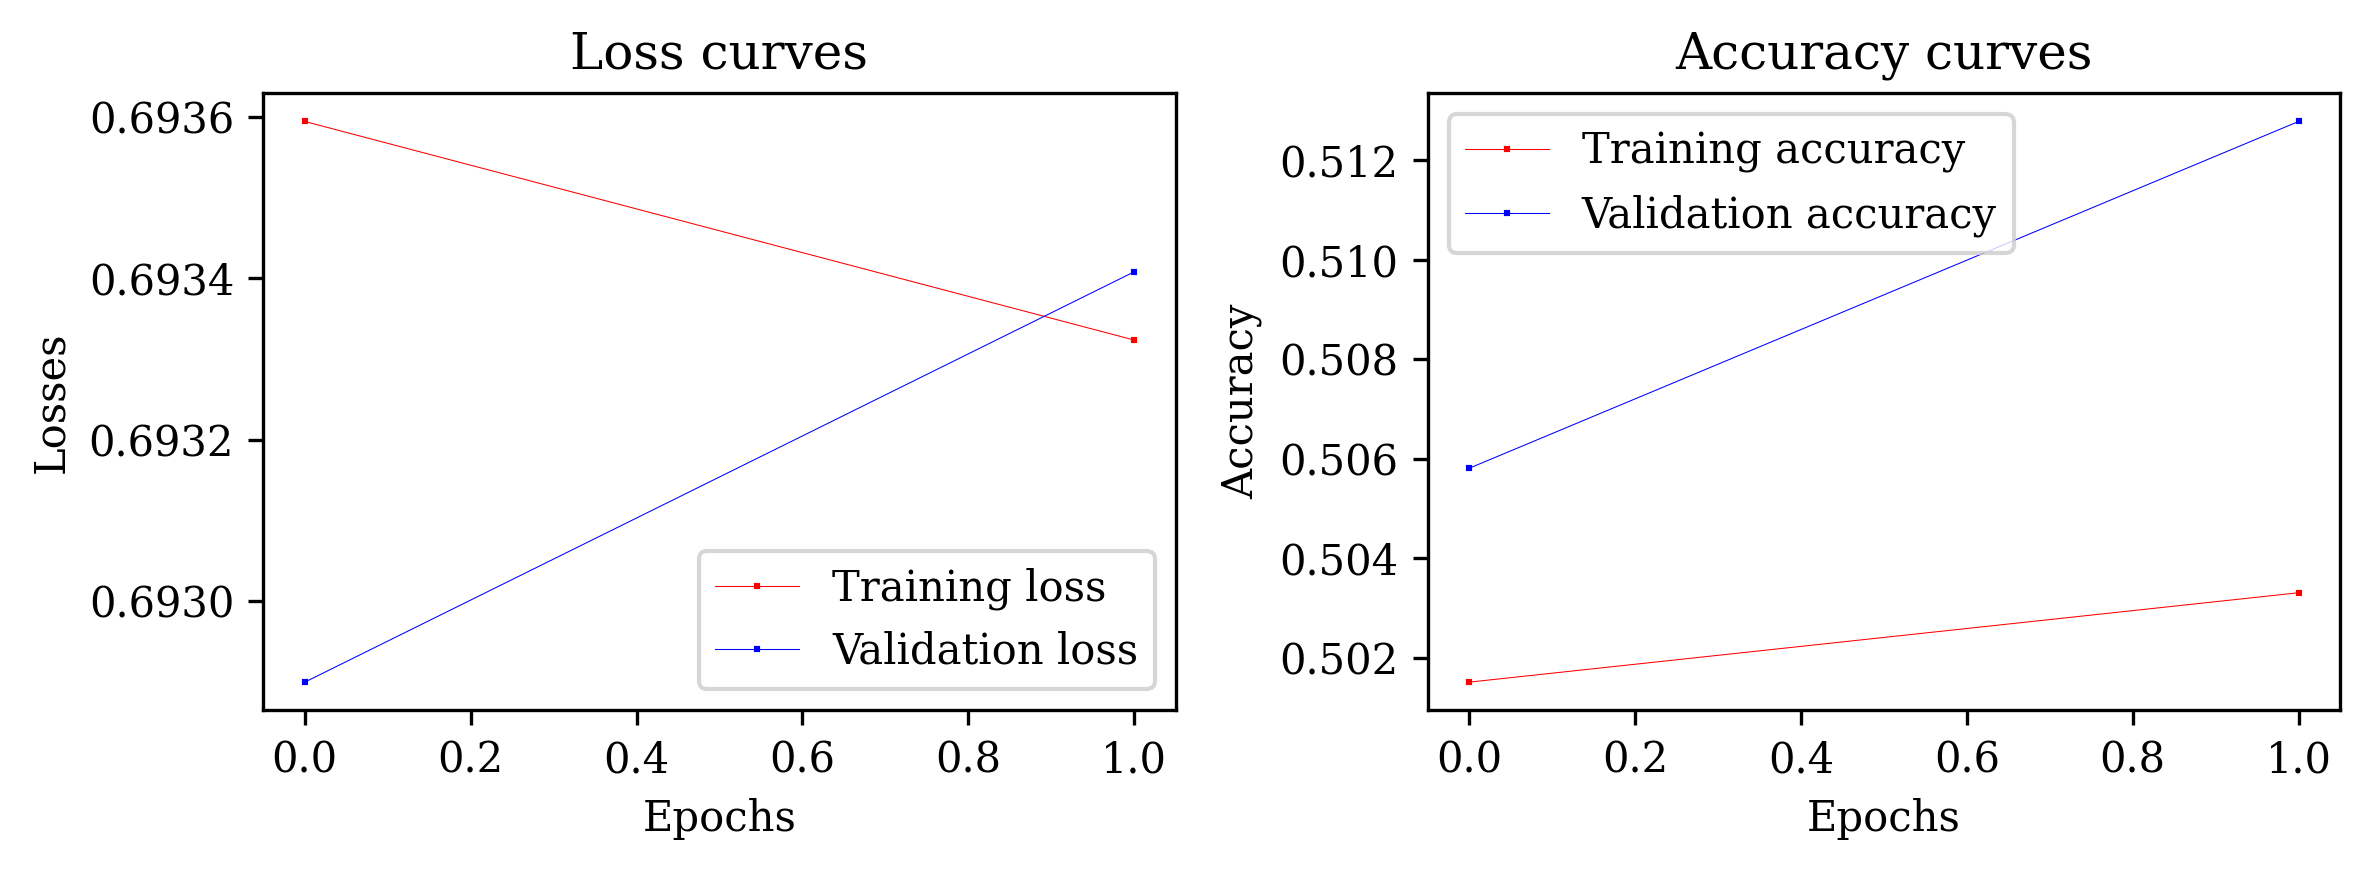

In [74]:
plt.rcParams["font.family"]="serif"
epochs = np.arange(0, len(train_val_metrics["Train loss"]))

fig,ax = plt.subplots(1,2, figsize=[8,3], dpi=300)
ax[0].plot(epochs, train_val_metrics["Train loss"], 'red', linestyle = '-', linewidth=0.25, marker = 's', mfc = 'k', markersize = 0.5, label = 'Training loss')
ax[0].plot(epochs, train_val_metrics["Validation loss"], 'blue', linestyle = '-', linewidth=0.25, marker = 's', mfc = 'k', markersize = 0.5, label = 'Validation loss')
ax[0].set_title('Loss curves')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Losses")
ax[0].legend()

ax[1].plot(epochs, train_val_metrics["Train accuracy"], 'red', linestyle = '-', linewidth=0.25, marker = 's', mfc = 'k', markersize = 0.5, label = 'Training accuracy')
ax[1].plot(epochs, train_val_metrics["Validation accuracy"], 'blue', linestyle = '-', linewidth=0.25, marker = 's', mfc = 'k', markersize = 0.5, label = 'Validation accuracy')
ax[1].set_title('Accuracy curves')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()
plt.savefig(curves_filename,dpi=199)
# plt.show()

In [76]:
model = SpatioTemporalSAGE(num_sage_layers, sage_hdim, dropout_prob, num_lstm_layers, lstm_hdim, training=False)
model.load_state_dict(torch.load(model_filename))
model.eval()

test_metrics = test(model)
formatted_accuracy = "{:.4f}".format(test_metrics[1])
formatted_loss = "{:.4f}".format(test_metrics[0])

print(f"Test loss: {formatted_loss}")
print(f"Test accuracy: {formatted_accuracy}")

test_loss = test_metrics[0]
test_accuracy = np.array([round(test_metrics[1], 4)])

np.savetxt(accuracy_filename, test_accuracy, fmt='%.4f')

C:\Users\samar\AppData\Local\Temp\ipykernel_29492\2829852161.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_filename))


Test loss: 0.6935
Test accuracy: 0.5000
